# Traditional machine learning with PCA features

This notebook explores the traditional machine techniques, and whether they could be used. This notebook deals with features extracted from PCA. 

## Preprocess and load data

Import and load all the data. Data is stored in AWS S3 bucket. It can also be stored locally, but then from `src/data/preprocess_data.py` the function `load_array_from_s3` should be replaced.

In [1]:
from typing import List
import datetime
import io
import os
import pickle
import torch

from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from efficientnet_pytorch import EfficientNet

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from src.data.preprocess_data import DatasetManager
from src.features.dimension_reduction import fit_pca, load_cnn_embedding, extract_cnn_features

# S3 bucket
import boto3
from dotenv import dotenv_values

Define constants to be used later. *DRIVE_PATH* and *MODEL_PATH* should be the root path of project and path for models, respectively

In [2]:
EMOTION_LIST = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
DRIVE_PATH = "/content/drive/My Drive/Loop Q prize"
MODEL_PATH = 'models/traditional'

# Set values
BATCH_SIZE = 8
TEST_SIZE = 0.2
VAL_SIZE = 0.2
N_EPOCHS = 100
INPUT_SIZE = 224
N_FEATURES = len(EMOTION_LIST)

Load all of the data in splits to a dictionary.

In [3]:
dataset_manager = DatasetManager(batch_size=BATCH_SIZE, test_size=TEST_SIZE, 
                        validation_size=VAL_SIZE, transform=None, 
                        test_transform=None)
data = dataset_manager.load_dataloaders(return_raw_data=True)

Unpack all of the data

In [4]:
X_train, X_test, X_val = [x[1] for x in data['X'].items()]
y_train, y_test, y_val = [x[1] for x in data['y'].items()]

## Feature extraction

We can get descriptors of the images in multiple different ways. 

#### PCA as image descriptor

Perform PCA on reasonable amount of components, 50.

In [5]:
pca, X_train_pca, X_test_pca, X_val_pca = fit_pca(X_train, X_test, X_val, n_components = 50)

Check cumulatively, how much responsibility first n components have. It seems like 90% of the variance is exaplined by 20 components, but 50 components is also very low representation compared to original, so all components were used

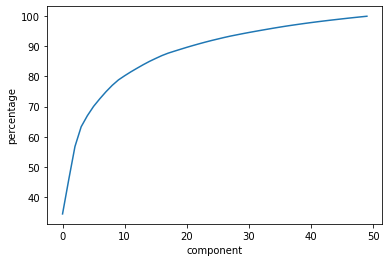

In [6]:
_ = plt.plot(100 * np.cumsum(pca.explained_variance_ / pca.explained_variance_.sum()))
plt.xlabel("component")
plt.ylabel("percentage")
plt.show()

#### Histogram of oriented Gradients

Histogram of oriented Gradients (HoG) constructs feature descriptors that take gradient orientation in to account. Visually inspecting the dataset, it seems like data is fairly free of occlusions and such, so HoG could make good sense to use as feature descriptor. pixels_per_cell was manually chosen to 10. Much lower would result in long feature vector, and much higher would then sacrifice in quality of predictions.

In [10]:
from skimage.feature import hog
from skimage import data, exposure

ppc = 10
train_imgs = [hog(x, orientations=8, pixels_per_cell=(ppc, ppc)) for x in X_train]
val_imgs = [hog(x, orientations=8, pixels_per_cell=(ppc, ppc)) for x in X_val]

X_train_hog = np.vstack(train_imgs)
X_val_hog = np.vstack(val_imgs)

#### CNN as feature extractor

CNN is also powerful feature extractor, and it will be used here to compare the results. The model will be EfficientNet. Embeddings are of size 1280x7x7, so we need to reduce their dimensionality.

In [27]:
model = EfficientNet.from_pretrained('efficientnet-b0')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()

Loaded pretrained weights for efficientnet-b0


EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=

Extract features, and save them locally. This needs to be done only once, and later we can load the features from disk. *np.vstack* takes only equal length arrays, so we only add batch if its of length *BATCH_SIZE*. 1280x7x7.

In [35]:
test_preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(INPUT_SIZE),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

dataset_manager = DatasetManager(batch_size=BATCH_SIZE, test_size=TEST_SIZE, 
                        validation_size=VAL_SIZE, transform=test_preprocess, 
                        test_transform=test_preprocess)

In [60]:
train_loader, test_loader, val_loader = dataset_manager.load_dataloaders()
# Train
embeddings, labels = extract_cnn_features(model, train_loader, BATCH_SIZE)
np.save('../data/processed/y_train_labels_b7.npy', np.vstack(labels))
np.save('../data/processed/X_train_embeddings_b7.npy', np.vstack(embeddings))
# Test
embeddings, labels = extract_cnn_features(moadel, test_loader, BATCH_SIZE)
np.save('../data/processed/y_test_labels_b7.npy', np.vstack(labels))
np.save('../data/processed/X_test_embeddings_b7.npy', np.vstack(embeddings))
# Val
embeddings, labels = extract_cnn_features(model, val_loader, BATCH_SIZE)
np.save('../data/processed/y_val_labels_b7.npy', np.vstack(labels))
np.save('../data/processed/X_val_embeddings_b7.npy', np.vstack(embeddings))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2015/2015 [03:42<00:00,  9.05it/s]


MemoryError: Unable to allocate 7.53 GiB for an array with shape (16112, 125440) and data type float32

Embeddings should be loaded from disk, as they take up to 6GB of ram. With np.memmap, we can load them sequentially from disk only when needed.

In [6]:
X_train_embed, y_train_cnn = load_cnn_embedding('train')
X_test_embed, y_test_cnn = load_cnn_embedding('test')
X_val_embed, y_val_cnn = load_cnn_embedding('val')

We will reduce the dimensionality with PCA, as its more efficient.

In [20]:
pca, X_train_cnn, X_test_cnn, X_val_cnn = fit_pca(X_train_embed, X_test_embed, X_val_embed, n_components=200)

## Train classifiers

In [8]:
from joblib import dump, load
from sklearn.base import clone
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

def save_classifiers(model: List, model_name: List[str]):
    for clf, name in zip(model, model_name):
        model_type = name.split('_')[0]
        if model_type == 'cnn':
            dump(clf, f'../models/cnn_features/{name}.joblib')
        if model_type == 'pca':
            dump(clf, f'../models/pca_features/{name}.joblib')
        if model_type == 'hog':
            dump(clf, f'../models/hog_features/{name}.joblib')
    
def train_sklearn_clf(clf, params, X_train, X_val, y_train, y_val):
    model = make_pipeline(StandardScaler(), 
                          HalvingGridSearchCV(clone(clf),
                                      param_grid=params,
                                      cv=2,
                                      refit=True))
    model = model.fit(X_train, y_train)
    score = model.score(X_val, y_val)
    return model, score

#### K-nearest neighbors

In [18]:
from sklearn.neighbors import KNeighborsClassifier


clf = KNeighborsClassifier()
param_grid = {'n_neighbors': [3, 5, 8]}
pca_knn, pca_knn_score = train_sklearn_clf(clf, param_grid, 
                                           X_train_pca, X_val_pca, 
                                           y_train, y_val)
hog_knn, hog_knn_score = train_sklearn_clf(clf, param_grid, 
                                           X_train_hog, X_val_hog, 
                                           y_train, y_val)
cnn_knn, cnn_knn_score = train_sklearn_clf(clf, param_grid, 
                                           X_train_cnn, X_val_cnn, 
                                           y_train_cnn, y_val_cnn)

# Save models
save_classifiers([pca_knn, hog_knn, cnn_knn], ['pca_knn', 'hog_knn', 'cnn_knn'])
print(f"hog: {hog_knn_score}, pca: {pca_knn_score}, cnn: {cnn_knn_score}")

KeyboardInterrupt: 

#### Logistic Regression

In [65]:
from sklearn.linear_model import LogisticRegression
from sklearn.kernel_approximation import Nystroem

clf = LogisticRegression()
param_grid = {'C': [0.2, 0.316, 1.0, 1.3],
             'max_iter': [2000], 'class_weight': ['balanced'],
             'warm_start': [True]}
pca_lr, pca_lr_score = train_sklearn_clf(clf, param_grid, 
                                         X_train_pca, X_val_pca, 
                                         y_train, y_val)
hog_lr, hog_lr_score = train_sklearn_clf(clf, param_grid, 
                                         X_train_hog, X_val_hog, 
                                         y_train, y_val)
cnn_lr, cnn_lr_score = train_sklearn_clf(clf, param_grid, 
                                         X_train_cnn, X_val_cnn, 
                                         y_train_cnn, y_val_cnn)

# Save models
save_classifiers([pca_lr, hog_lr, cnn_lr], ['pca_lr', 'hog_lr', 'cnn_lr'])
print(f"hog: {hog_lr_score}, pca: {pca_lr_score}, CNN: {cnn_lr_score}")

KeyboardInterrupt: 

#### XGBoost

In [46]:
from xgboost import XGBClassifier

clf = XGBClassifier()
param_grid = {
    'learning_rate': np.array([0.01,0.001]),
    'n_estimators': np.array([100,200,300,400]),
    'subsample': np.array([0.7,0.8,0.9]),
    'max_depth': np.array([10,11,12,14,16,17]),
    'lambda': np.array([1]),
    'gamma': np.array([0])
}

pca_xgb, pca_xgb_score = train_sklearn_clf(clf, param_grid, 
                                           X_train_pca, X_val_pca,
                                           y_train, y_val)
hog_xgb, hog_xgb_score = train_sklearn_clf(clf, param_grid, 
                                           X_train_hog, X_val_hog, 
                                           y_train, y_val)
cnn_xgb, cnn_xgb_score = train_sklearn_clf(clf, param_grid, 
                                           X_train_cnn, X_val_cnn, 
                                           y_train_cnn, y_val_cnn)

save_classifiers([pca_xgb, hog_xgb, cnn_xgb], ['pca_xgb', 'hog_xgb', 'cnn_xgb'])
print(f"hog: {hog_xgb_score}, pca: {pca_xgb_score}, cnn: {cnn_xgb_score}")

KeyboardInterrupt: 

#### LinearSVC

In [61]:
from sklearn.svm import LinearSVC
param_grid = {'C': [0.5, 2, 8, 15],
             'dual': [False],
             'loss': ['squared_hinge'],
             'class_weight': ['balanced'],
              'max_iter': [1000],
              'tol': [1e-1, 1e-2, 1e-3]
             }
clf = LinearSVC()
pca_svc, pca_svc_score = train_sklearn_clf(clf, param_grid, 
                                           X_train_pca, X_val_pca, 
                                           y_train, y_val)
hog_svc, hog_svc_score = train_sklearn_clf(clf, param_grid, 
                                           X_train_hog, X_val_hog, 
                                           y_train, y_val)
cnn_svc, cnn_svc_score = train_sklearn_clf(clf, param_grid, 
                                           X_train_cnn, X_val_cnn, 
                                           y_train_cnn, y_val_cnn)

save_classifiers([pca_svc, hog_svc, cnn_svc], ['pca_svc', 'hog_svc', 'cnn_svc'])
print(f"hog: {hog_svc_score}, pca: {pca_svc_score}, CNN: {cnn_svc_score}")

C:\Users\teemu\anaconda3\envs\pytorchEnv\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\teemu\anaconda3\envs\pytorchEnv\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\teemu\anaconda3\envs\pytorchEnv\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\teemu\anaconda3\envs\pytorchEnv\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\teemu\anaconda3\envs\pytorchEnv\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear f

hog: 0.34077380952380953, pca: 0.3291170634920635, CNN: 0.5064484126984127


#### RBF SVC

Linear SVC assumes we can separate features with linear kernel mapping. However this might not be the case, especially with low amount of features (PCA reduced data). We use Radial Basis Function -kernel to map data to infinite dimensional space, where accuracy is guaranteed to be higher, but so is the training and inference time.

In [40]:
from sklearn.svm import SVC

clf = SVC()
param_grid = {'kernel': ['rbf'],
             'C': [2, 4, 6, 8],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
             'class_weight': ['balanced']}
pca_rbf_svc, pca_rbf_svc_score = train_sklearn_clf(clf, param_grid, 
                                                   X_train_pca, X_val_pca, 
                                                   y_train, y_val)
hog_rbf_svc, hog_rbf_svc_score = train_sklearn_clf(clf, param_grid, 
                                                   X_train_hog, X_val_hog, 
                                                   y_train, y_val)
cnn_rbf_svc, cnn_rbf_svc_score = train_sklearn_clf(clf, param_grid, 
                                                   X_train_cnn, X_val_cnn, 
                                                   y_train_cnn, y_val_cnn)

# save_classifiers([pca_rbf_svc, hog_rbf_svc, cnn_rbf_svc], ['pca_rbf_svc', 'hog_rbf_svc', 'cnn_rgf_svc'])
print(f"hog: {hog_rbf_svc_score}, pca: {pca_rbf_svc_score}, CNN: {cnn_rbf_svc_score}")

hog: 0.4937996031746032, pca: 0.4166666666666667, CNN: 0.5858134920634921


#### SGD classifier

In [ ]:
from sklearn.linear_model import SGDClassifier

param_grid = {
    'loss': ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'],
    'alpha': [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e+1, 1e+2],
    'eta0': [1, 10, 100],
    'penalty': ['l1', 'l2', 'elasticnet'],
    'max_iter': [2000],
    'early_stopping': [True],
    'class_weight': ['balanced', None]
}
clf = SGDClassifier()
pca_sgd_svc, pca_sgd_svc_score = train_sklearn_clf(clf, param_grid, 
                                                   X_train_pca, X_val_pca, y_train, y_val)
hog_sgd_svc, hog_sgd_svc_score = train_sklearn_clf(clf, param_grid, 
                                                   X_train_hog, X_val_hog, y_train, y_val)
cnn_sgd_svc, cnn_sgd_svc_score = train_sklearn_clf(clf, param_grid, 
                                                   X_train_cnn, X_val_cnn, y_train_cnn, y_val_cnn)

# save_classifiers([pca_sgd_svc, hog_sgd_svc, cnn_sgd_svc], ['pca_sgd_svc', 'hog_sgd_svc', 'cnn_sgd_svc'])
print(f"hog: {hog_sgd_svc_score}, pca: {pca_sgd_svc_score}, CNN: {cnn_sgd_svc_score}")